# 6.支持向量机（SVM）和SMO算法

In [90]:
import numpy as np
from numpy import *
from time import sleep
import matplotlib.pyplot as plt
%matplotlib inline

## 6.1.简化版SMO算法处理小规模数据集
### 6.1.1.辅助函数

In [2]:
def loadDataSet(fileName):
    """
    读取数据集
    参数：
        fileName -- 文件名
    返回：
        dataMat -- 数据矩阵
        label -- 标签矩阵
    """
    #新建数据和标签矩阵列表
    dataMat = []; labelMat = []
    #获得文件指针
    fr = open(fileName)
    #一行行读取
    for line in fr.readlines():
        #以制表符分割
        lineArr = line.strip().split('\t')
        #数据1、2列添加到数据矩阵
        dataMat.append([np.float(lineArr[0]), np.float(lineArr[1])])
        #数据3列添加到标签矩阵
        labelMat.append(np.float(lineArr[2]))
    return dataMat,labelMat

In [3]:
def selectJrand(i,m):
    """
    随机选取和i不同的j
    参数:
        i -- 第一个alpha的下标
        m -- alpha的个数
    返回：
        j -- 随机的值
    """
    j=i
    while (j==i):
        j = np.int(np.random.uniform(0,m))
    return j

In [4]:
def clipAlpha(aj,H,L):
    """
    约束alpha
    参数：
        aj -- 迭代得到的未约束alpha的值
        H -- 上界
        L -- 下界
    返回：
        aj -- 约束后的alpha
    """
    if aj > H: 
        aj = H
    if L > aj:
        aj = L
    return aj

### 6.1.2.简化的SMO算法

In [5]:
def smoSimple(dataMatIn, classLabels, C, toler, maxIter):
    """
    简化的SMO算法
    参数：
        dataMatIn -- 输入数据矩阵
        classLabels -- 标签类列表
        C -- 权重超参数
        toler -- 容错率
        maxIter -- 最大迭代次数
    返回：
        b -- 更新的偏差参数
        alphas -- 更新的alpha参数向量
    """
    #数据和标签转化为矩阵形式
    dataMatrix = np.array(dataMatIn); labelMat = np.array(classLabels).reshape(-1, 1)
    #偏差参数初始化
    #记录数据矩阵的维度
    b = 0; m,n = np.shape(dataMatrix)
    #初始化alpha向量为全0
    alphas = np.zeros((m,1))
    #初始化迭代次数计数器
    iter = 0
    #当迭代次数小于最大迭代次数时
    while (iter < maxIter):
        #alpha对修改次数计数器
        alphaPairsChanged = 0
        #寻找可优化的alpha
        for i in range(m):
            fXi = np.float(np.dot((alphas*labelMat).T, np.dot(dataMatrix, dataMatrix[i:i+1,:].T))) + b
            Ei = fXi - np.float(labelMat[i, 0])
            #检查是否有元素违背KKT条件
            if ((labelMat[i, 0]*Ei < -toler) and (alphas[i, 0] < C)) or ((labelMat[i, 0]*Ei > toler) and (alphas[i, 0] > 0)):
                #随机选择j
                j = selectJrand(i,m)
                fXj = np.float(np.dot((alphas*labelMat).T, np.dot(dataMatrix, dataMatrix[j:j+1,:].T))) + b
                Ej = fXj - np.float(labelMat[j, 0])
                #提取旧的alphai和alphaj
                alphaIold = alphas[i, 0].copy(); alphaJold = alphas[j, 0].copy();
                #如果i和j的标签不同
                if (labelMat[i, 0] != labelMat[j, 0]):
                    L = max(0, alphas[j, 0] - alphas[i, 0])
                    H = min(C, C + alphas[j, 0] - alphas[i, 0])
                else:
                    L = max(0, alphas[j, 0] + alphas[i, 0] - C)
                    H = min(C, alphas[j, 0] + alphas[i, 0])
                #若上界等于下界，就执行下一次循序
                if L==H:  continue
                #计算最优修改量
                eta = 2.0 * np.dot(dataMatrix[i:i+1,:], dataMatrix[j:j+1,:].T) - np.dot(dataMatrix[i:i+1,:], dataMatrix[i:i+1,:].T) - np.dot(dataMatrix[j:j+1,:], dataMatrix[j:j+1,:].T)
                if eta >= 0:  continue
                #更新alphaj
                alphas[j, 0] -= labelMat[j, 0]*(Ei - Ej)/eta
                #约束alphaj
                alphas[j, 0] = clipAlpha(alphas[j, 0],H,L)
                #判断精度是否满足要求，是，则执行下一次循环
                if (abs(alphas[j, 0] - alphaJold) < 0.00001):  continue
                #修改i的量和j相同，但是方向相反，保证约束条件成立
                alphas[i, 0] += labelMat[j, 0]*labelMat[i, 0]*(alphaJold - alphas[j, 0])
                #计算新的b
                b1 = b - Ei- labelMat[i, 0]*(alphas[i, 0]-alphaIold)*np.dot(dataMatrix[i:i+1,:], dataMatrix[i:i+1,:].T) - labelMat[j, 0]*(alphas[j, 0]-alphaJold)*np.dot(dataMatrix[i:i+1,:], dataMatrix[j:j+1,:].T)
                b2 = b - Ej- labelMat[i, 0]*(alphas[i, 0]-alphaIold)*np.dot(dataMatrix[i:i+1,:], dataMatrix[j:j+1,:].T) - labelMat[j, 0]*(alphas[j, 0]-alphaJold)*np.dot(dataMatrix[j:j+1,:], dataMatrix[j:j+1,:].T)
                if (0 < alphas[i, 0]) and (C > alphas[i, 0]): b = b1
                elif (0 < alphas[j, 0]) and (C > alphas[j, 0]): b = b2
                else: b = (b1 + b2)/2.0
                #更新alpha对修改次数计数器
                alphaPairsChanged += 1
                #打印更新次数
                #print("循环次数: {} alpha:{}, alpha对修改了 {} 次".format(iter,i,alphaPairsChanged))
        if (alphaPairsChanged == 0): iter += 1
        else: iter = 0
        #print("迭代次数: {}".format(iter))
    return b,alphas

测试函数

In [6]:
dataArr, labelArr = loadDataSet("testSet.txt")
b, alphas = smoSimple(dataArr, labelArr, 0.6, 0.001, 40)
print("b = {}".format(b))
print("大于0的alpha\n{}".format(alphas[alphas > 0]))

b = [[-3.84505534]]
大于0的alpha
[ 0.1277133   0.24197161  0.36968491]


In [7]:
for i in range(alphas.shape[0]):
    if alphas[i, 0] > 0.0:
        print(dataArr[i], labelArr[i])

[4.658191, 3.507396] -1.0
[3.457096, -0.082216] -1.0
[6.080573, 0.418886] 1.0


### 6.1.3.可视化数据

In [18]:
def visualizeData(dataArr, labelArr, b, alphas):
    """
    可视化数据
    参数：
        dataArr -- 参数矩阵
        labelArr -- 标签矩阵
        b -- 超平面的常数项
        alphas -- 超平面的参数
    返回：
        无 -- 直接绘图
    """
    dataMat = np.array(dataArr)
    labelMat = np.array(labelArr).reshape(-1, 1)
    posIndex = np.squeeze(labelMat > 0.0)
    negIndex = np.squeeze(labelMat < 0.0)
    svIndex = np.squeeze(alphas > 0.0)
    posData = dataMat[posIndex, :]
    negData = dataMat[negIndex, :]
    svData = dataMat[svIndex, :]
    plt.scatter(posData[:, 0], posData[:, 1], marker = 's', color = 'b')
    plt.scatter(negData[:, 0], negData[:, 1], marker = '.', color = 'r')
    plt.scatter(svData[:, 0], svData[:, 1], s = 200, marker = 'o', c='',edgecolors='g')
    plt.legend(("postive point", "negative point", "support vector"))
    w = np.dot((alphas * labelMat).T, dataMat)
    x0 = np.array([2, 8])
    x1 = -(w[0, 0] * x0 + np.squeeze(b)) / w[0, 1]
    plt.plot(x0, x1, color = 'y')

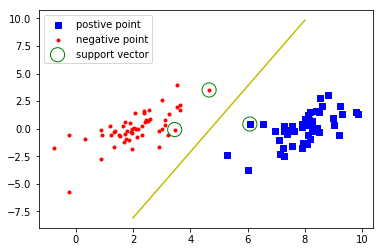

In [19]:
visualizeData(dataArr, labelArr, b, alphas)

## 6.2.完整版Platt SMO的支持函数  

### 6.2.1.Platt SMO支持函数  

In [44]:
class optStructK:
    def __init__(self,dataMatIn, classLabels, C, toler):
        self.X = dataMatIn
        self.labelMat = classLabels
        self.C = C
        self.tol = toler
        self.m = np.shape(dataMatIn)[0]
        self.alphas = np.zeros((self.m,1))
        self.b = 0
        #误差缓存
        self.eCache = np.zeros((self.m,2))

In [45]:
def calcEkK(oS, k):
    fXk = np.float(np.dot((oS.alphas * oS.labelMat).T, np.dot(oS.X, oS.X[k,:].T))) + oS.b
    Ek = fXk - np.float(oS.labelMat[k])
    return Ek

In [46]:
def selectJK(i, oS, Ei):
    """
    内循环选择alpha的启发式算法
    参数：
        i -- 外循环alpha的下标
        oS -- 类
        Ei -- 误差
    返回：
        j -- 选择的alpha的下标
        Ej -- 误差
    """
    #初始化
    maxK = -1; maxDeltaE = 0; Ej = 0
    oS.eCache[i] = [1,Ei]
    #选择合理的集合
    validEcacheList = np.nonzero(oS.eCache[:,0])[0]
    if (len(validEcacheList)) > 1:
        #选择最大步长的alpha
        for k in validEcacheList:
            #不重复计算
            if k == i: continue
            #计算误差
            Ek = calcEkK(oS, k)
            #计算步长
            deltaE = abs(Ei - Ek)
            #记录最佳选择
            if (deltaE > maxDeltaE):
                maxK = k; maxDeltaE = deltaE; Ej = Ek
        return maxK, Ej
    #没有合理值
    else:
        #随机选择
        j = selectJrand(i, oS.m)
        Ej = calcEkK(oS, j)
    return j, Ej

In [47]:
def updateEkK(oS, k):
    #在alpha更新后存储计算得到的误差
    Ek = calcEkK(oS, k)
    oS.eCache[k] = [1,Ek]

In [58]:
def innerLK(i, oS):
    #计算误差
    Ei = calcEkK(oS, i)
    #找出不满足KKT条件的alpha
    if ((oS.labelMat[i, 0]*Ei < -oS.tol) and (oS.alphas[i, 0] < oS.C)) or ((oS.labelMat[i, 0]*Ei > oS.tol) and (oS.alphas[i, 0] > 0)):
        #选择j
        j,Ej = selectJK(i, oS, Ei)
        #存储旧的值
        alphaIold = oS.alphas[i, 0].copy(); alphaJold = oS.alphas[j, 0].copy();
        #两种情况求边界值
        if (oS.labelMat[i, 0] != oS.labelMat[j, 0]):
            L = max(0, oS.alphas[j, 0] - oS.alphas[i, 0])
            H = min(oS.C, oS.C + oS.alphas[j, 0] - oS.alphas[i, 0])
        else:
            L = max(0, oS.alphas[j, 0] + oS.alphas[i, 0] - oS.C)
            H = min(oS.C, oS.alphas[j, 0] + oS.alphas[i, 0])
        if L==H: return 0
        #计算变化量
        eta = 2.0 * np.dot(oS.X[i:i+1,:], oS.X[j:j+1,:].T) - np.dot(oS.X[i:i+1,:], oS.X[i:i+1,:].T) - np.dot(oS.X[j:j+1,:], oS.X[j:j+1,:].T)
        if eta >= 0: return 0
        #更新alpha
        oS.alphas[j, 0] -= oS.labelMat[j, 0]*(Ei - Ej)/eta
        #约束alpha
        oS.alphas[j, 0] = clipAlpha(oS.alphas[j, 0],H,L)
        updateEkK(oS, j)
        if (abs(oS.alphas[j, 0] - alphaJold) < 0.00001): return 0
        oS.alphas[i, 0] += oS.labelMat[j, 0]*oS.labelMat[i, 0]*(alphaJold - oS.alphas[j, 0])
        updateEkK(oS, i)
        b1 = oS.b - Ei- oS.labelMat[i, 0]*(oS.alphas[i, 0]-alphaIold)*np.dot(oS.X[i:i+1,:], oS.X[i:i+1,:].T) - oS.labelMat[j, 0]*(oS.alphas[j, 0]-alphaJold)*np.dot(oS.X[i:i+1,:], oS.X[j:j+1,:].T)
        b2 = oS.b - Ej- oS.labelMat[i, 0]*(oS.alphas[i, 0]-alphaIold)*np.dot(oS.X[i:i+1,:], oS.X[j:j+1,:].T) - oS.labelMat[j, 0]*(oS.alphas[j, 0]-alphaJold)*np.dot(oS.X[j:j+1,:], oS.X[j:j+1,:].T)
        if (0 < oS.alphas[i, 0]) and (oS.C > oS.alphas[i, 0]): oS.b = b1
        elif (0 < oS.alphas[j, 0]) and (oS.C > oS.alphas[j, 0]): oS.b = b2
        else: oS.b = (b1 + b2)/2.0
        return 1
    else: return 0

In [56]:
def smoPK(dataMatIn, classLabels, C, toler, maxIter):
    #建立类变量
    oS = optStructK(np.array(dataMatIn),np.array(classLabels).reshape(-1, 1),C,toler)
    iter = 0
    entireSet = True; alphaPairsChanged = 0
    #执行循环
    while (iter < maxIter) and ((alphaPairsChanged > 0) or (entireSet)):
        alphaPairsChanged = 0
        if entireSet:
            #遍历所有
            for i in range(oS.m):        
                alphaPairsChanged += innerLK(i,oS)
                #print("fullSet, iter: {} i:{}, pairs changed {}".format(iter,i,alphaPairsChanged))
            iter += 1
        else:
            #遍历非边界值
            nonBoundIs = np.nonzero((oS.alphas > 0) * (oS.alphas < C))[0]
            for i in nonBoundIs:
                alphaPairsChanged += innerLK(i,oS)
                #print("non-bound, iter: {} i:{}, pairs changed {}".format(iter,i,alphaPairsChanged))
            iter += 1
        if entireSet: entireSet = False 
        elif (alphaPairsChanged == 0): entireSet = True  
        #print("iteration number: {}".format(iter))
    return oS.b,oS.alphas

In [59]:
dataArr, labelArr = loadDataSet("testSet.txt")
b, alphas = smoPK(dataArr, labelArr, 0.6, 0.001, 40)
print("b = {}\nalphas[alphas > 0] = {}".format(b, alphas[alphas > 0]))

b = [[-2.89901748]]
alphas[alphas > 0] = [ 0.06961952  0.0169055   0.0169055   0.0272699   0.04522972  0.0272699
  0.0243898   0.06140181  0.06140181]


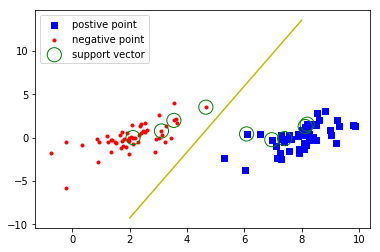

In [60]:
visualizeData(dataArr, labelArr, b, alphas)

## 6.3.引入核函数
### 6.3.1.在线性SVM的基础上进行改动

In [111]:
def kernelTrans(X, A, kTup): #calc the kernel or transform data to a higher dimensional space
    m,n = shape(X)
    K = mat(zeros((m,1)))
    if kTup[0]=='lin': K = X * A.T   #linear kernel
    elif kTup[0]=='rbf':
        for j in range(m):
            deltaRow = X[j,:] - A
            K[j] = np.dot(deltaRow, deltaRow.T)
        K = exp(K/(-1*kTup[1]**2)) #divide in NumPy is element-wise not matrix like Matlab
    else: raise NameError('Houston We Have a Problem -- \
    That Kernel is not recognized')
    return K

In [92]:
class optStruct:
    def __init__(self,dataMatIn, classLabels, C, toler, kTup):  # Initialize the structure with the parameters 
        self.X = dataMatIn
        self.labelMat = classLabels
        self.C = C
        self.tol = toler
        self.m = shape(dataMatIn)[0]
        self.alphas = mat(zeros((self.m,1)))
        self.b = 0
        self.eCache = mat(zeros((self.m,2))) #first column is valid flag
        self.K = mat(zeros((self.m,self.m)))
        for i in range(self.m):
            self.K[:,i] = kernelTrans(self.X, self.X[i,:], kTup)

In [93]:
def calcEk(oS, k):
    fXk = float(multiply(oS.alphas,oS.labelMat).T*oS.K[:,k] + oS.b)
    Ek = fXk - float(oS.labelMat[k])
    return Ek

In [94]:
def selectJ(i, oS, Ei):         #this is the second choice -heurstic, and calcs Ej
    maxK = -1; maxDeltaE = 0; Ej = 0
    oS.eCache[i] = [1,Ei]  #set valid #choose the alpha that gives the maximum delta E
    validEcacheList = nonzero(oS.eCache[:,0].A)[0]
    if (len(validEcacheList)) > 1:
        for k in validEcacheList:   #loop through valid Ecache values and find the one that maximizes delta E
            if k == i: continue #don't calc for i, waste of time
            Ek = calcEk(oS, k)
            deltaE = abs(Ei - Ek)
            if (deltaE > maxDeltaE):
                maxK = k; maxDeltaE = deltaE; Ej = Ek
        return maxK, Ej
    else:   #in this case (first time around) we don't have any valid eCache values
        j = selectJrand(i, oS.m)
        Ej = calcEk(oS, j)
    return j, Ej

In [95]:
def updateEk(oS, k):#after any alpha has changed update the new value in the cache
    Ek = calcEk(oS, k)
    oS.eCache[k] = [1,Ek]

In [102]:
def innerL(i, oS):
    Ei = calcEk(oS, i)
    if ((oS.labelMat[i]*Ei < -oS.tol) and (oS.alphas[i] < oS.C)) or ((oS.labelMat[i]*Ei > oS.tol) and (oS.alphas[i] > 0)):
        j,Ej = selectJ(i, oS, Ei) #this has been changed from selectJrand
        alphaIold = oS.alphas[i].copy(); alphaJold = oS.alphas[j].copy();
        if (oS.labelMat[i] != oS.labelMat[j]):
            L = max(0, oS.alphas[j] - oS.alphas[i])
            H = min(oS.C, oS.C + oS.alphas[j] - oS.alphas[i])
        else:
            L = max(0, oS.alphas[j] + oS.alphas[i] - oS.C)
            H = min(oS.C, oS.alphas[j] + oS.alphas[i])
        if L==H: return 0
        eta = 2.0 * oS.K[i,j] - oS.K[i,i] - oS.K[j,j] #changed for kernel
        if eta >= 0: return 0
        oS.alphas[j] -= oS.labelMat[j]*(Ei - Ej)/eta
        oS.alphas[j] = clipAlpha(oS.alphas[j],H,L)
        updateEk(oS, j) #added this for the Ecache
        if (abs(oS.alphas[j] - alphaJold) < 0.00001): return 0
        oS.alphas[i] += oS.labelMat[j]*oS.labelMat[i]*(alphaJold - oS.alphas[j])#update i by the same amount as j
        updateEk(oS, i) #added this for the Ecache                    #the update is in the oppostie direction
        b1 = oS.b - Ei- oS.labelMat[i]*(oS.alphas[i]-alphaIold)*oS.K[i,i] - oS.labelMat[j]*(oS.alphas[j]-alphaJold)*oS.K[i,j]
        b2 = oS.b - Ej- oS.labelMat[i]*(oS.alphas[i]-alphaIold)*oS.K[i,j]- oS.labelMat[j]*(oS.alphas[j]-alphaJold)*oS.K[j,j]
        if (0 < oS.alphas[i]) and (oS.C > oS.alphas[i]): oS.b = b1
        elif (0 < oS.alphas[j]) and (oS.C > oS.alphas[j]): oS.b = b2
        else: oS.b = (b1 + b2)/2.0
        return 1
    else: return 0

In [103]:
def smoP(dataMatIn, classLabels, C, toler, maxIter,kTup=('lin', 0)):    #full Platt SMO
    oS = optStruct(mat(dataMatIn),mat(classLabels).transpose(),C,toler, kTup)
    iter = 0
    entireSet = True; alphaPairsChanged = 0
    while (iter < maxIter) and ((alphaPairsChanged > 0) or (entireSet)):
        alphaPairsChanged = 0
        if entireSet:   #go over all
            for i in range(oS.m):        
                alphaPairsChanged += innerL(i,oS)
                #print("fullSet, iter: %d i:%d, pairs changed %d" % (iter,i,alphaPairsChanged))
            iter += 1
        else:#go over non-bound (railed) alphas
            nonBoundIs = nonzero((oS.alphas.A > 0) * (oS.alphas.A < C))[0]
            for i in nonBoundIs:
                alphaPairsChanged += innerL(i,oS)
                #print( "non-bound, iter: %d i:%d, pairs changed %d" % (iter,i,alphaPairsChanged))
            iter += 1
        if entireSet: entireSet = False #toggle entire set loop
        elif (alphaPairsChanged == 0): entireSet = True  
        #print( "iteration number: %d" % iter)
    return oS.b,oS.alphas

In [104]:
def calcWs(alphas,dataArr,classLabels):
    X = mat(dataArr); labelMat = mat(classLabels).transpose()
    m,n = shape(X)
    w = zeros((n,1))
    for i in range(m):
        w += multiply(alphas[i]*labelMat[i],X[i,:].T)
    return w

### 6.3.2.在测试中使用核函数

In [105]:
def testRbf(k1=1.3):
    dataArr,labelArr = loadDataSet('testSetRBF.txt')
    b,alphas = smoP(dataArr, labelArr, 200, 0.0001, 10000, ('rbf', k1)) #C=200 important
    datMat=mat(dataArr); labelMat = mat(labelArr).transpose()
    svInd=nonzero(alphas.A>0)[0]
    sVs=datMat[svInd] #get matrix of only support vectors
    labelSV = labelMat[svInd];
    print( "there are %d Support Vectors" % shape(sVs)[0])
    m,n = shape(datMat)
    errorCount = 0
    for i in range(m):
        kernelEval = kernelTrans(sVs,datMat[i,:],('rbf', k1))
        predict=kernelEval.T * multiply(labelSV,alphas[svInd]) + b
        if sign(predict)!=sign(labelArr[i]): errorCount += 1
    print( "the training error rate is: %f" % (float(errorCount)/m))
    dataArr,labelArr = loadDataSet('testSetRBF2.txt')
    errorCount = 0
    datMat=mat(dataArr); labelMat = mat(labelArr).transpose()
    m,n = shape(datMat)
    for i in range(m):
        kernelEval = kernelTrans(sVs,datMat[i,:],('rbf', k1))
        predict=kernelEval.T * multiply(labelSV,alphas[svInd]) + b
        if sign(predict)!=sign(labelArr[i]): errorCount += 1    
    print( "the test error rate is: %f" % (float(errorCount)/m) )

In [106]:
testRbf()

there are 30 Support Vectors
the training error rate is: 0.130000
the test error rate is: 0.150000


In [107]:
def img2vector(filename):
    returnVect = np.zeros((1,1024))
    fr = open(filename)
    for i in range(32):
        lineStr = fr.readline()
        for j in range(32):
            returnVect[0,32*i+j] = np.int(lineStr[j])
    return returnVect

In [108]:
def loadImages(dirName):
    from os import listdir
    hwLabels = []
    trainingFileList = listdir(dirName)           #load the training set
    m = len(trainingFileList)
    trainingMat = np.zeros((m,1024))
    for i in range(m):
        fileNameStr = trainingFileList[i]
        fileStr = fileNameStr.split('.')[0]     #take off .txt
        classNumStr = np.int(fileStr.split('_')[0])
        if classNumStr == 9: hwLabels.append(-1)
        else: hwLabels.append(1)
        trainingMat[i,:] = img2vector('%s/%s' % (dirName, fileNameStr))
    return trainingMat, hwLabels 

In [114]:
def testDigits(kTup=('rbf', 10)):
    dataArr,labelArr = loadImages('trainingDigits')
    b,alphas = smoP(dataArr, labelArr, 200, 0.0001, 10000, kTup)
    datMat=mat(dataArr); labelMat = mat(labelArr).transpose()
    svInd=nonzero(alphas.A>0)[0]
    sVs=datMat[svInd] 
    labelSV = labelMat[svInd];
    print ("there are %d Support Vectors" % shape(sVs)[0])
    m,n = shape(datMat)
    errorCount = 0
    for i in range(m):
        kernelEval = kernelTrans(sVs,datMat[i,:],kTup)
        predict=kernelEval.T * multiply(labelSV,alphas[svInd]) + b
        if sign(predict)!=sign(labelArr[i]): errorCount += 1
    print ("the training error rate is: %f" % (float(errorCount)/m))
    dataArr,labelArr = loadImages('testDigits')
    errorCount = 0
    datMat=mat(dataArr); labelMat = mat(labelArr).transpose()
    m,n = shape(datMat)
    for i in range(m):
        kernelEval = kernelTrans(sVs,datMat[i,:],kTup)
        predict=kernelEval.T * multiply(labelSV,alphas[svInd]) + b
        if sign(predict)!=sign(labelArr[i]): errorCount += 1    
    print ("the test error rate is: %f" % (float(errorCount)/m) )

In [115]:
testDigits(('rbf', 20))

there are 61 Support Vectors
the training error rate is: 0.000000
the test error rate is: 0.010753
